<a href="https://colab.research.google.com/github/ArsalanKhan17/Covid-Xray-Classification/blob/main/Covid_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the data

In [ ]:
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip 

## Import libraries

In [3]:
#setup colab
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [4]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [5]:
#Extracting filenames iteratively

base_path = 'COVID-19 Radiography Database'
categories = ['COVID','NORMAL','Viral Pneumonia']

#load file names
fnames = []

for category in categories:
  xray_folder = os.path.join(base_path, category)
  file_names = os.listdir(xray_folder)
  full_path = [os.path.join(xray_folder, file_name) for file_name in file_names]
  fnames.append(full_path)

print('number of images for each category: ', [len(f) for f in fnames])
print(fnames[0:4])

number of images for each category:  [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (1071).png', 'COVID-19 Radiography Database/COVID/COVID (447).png', 'COVID-19 Radiography Database/COVID/COVID (386).png', 'COVID-19 Radiography Database/COVID/COVID (28).png', 'COVID-19 Radiography Database/COVID/COVID (338).png', 'COVID-19 Radiography Database/COVID/COVID (370).png', 'COVID-19 Radiography Database/COVID/COVID (662).png', 'COVID-19 Radiography Database/COVID/COVID (485).png', 'COVID-19 Radiography Database/COVID/COVID (353).png', 'COVID-19 Radiography Database/COVID/COVID (65).png', 'COVID-19 Radiography Database/COVID/COVID (530).png', 'COVID-19 Radiography Database/COVID/COVID (404).png', 'COVID-19 Radiography Database/COVID/COVID (993).png', 'COVID-19 Radiography Database/COVID/COVID (615).png', 'COVID-19 Radiography Database/COVID/COVID (258).png', 'COVID-19 Radiography Database/COVID/COVID (373).png', 'COVID-19 Radiography Database/COVID/COVID (1152).png', 'COVID-

In [6]:
#define a preprocessor function to apply on each image

def preprocessor(data, shape = (192, 192)):
    """
    This function will read in an image and resize and min-max transform it

    params:
      data:
          unprocessed image
    
    returns:
      X:
        numpy array of processed image
      
    """

    img = cv2.imread(data) #Read in image from filepath
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (192, 192)) #Change height and width
    img = img / 255.0 #min-max transform

    X = np.array(img) #convert to numpy array

    return X

preprocessor('/content/COVID-19 Radiography Database/COVID/COVID (1).png')

array([[[0.50980392, 0.50980392, 0.50980392],
        [0.01960784, 0.01960784, 0.01960784],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.35294118, 0.35294118, 0.35294118]],

       [[0.07843137, 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.0627451 , 0.0627451 , 0.0627451 ]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.01960784, 0.01960784, 0.01960784],
        [0.08235294, 0.08235294, 0.08235294]],

       ...,

       [[0.23921569, 0.23921569, 0.23921569],
        [0.24705882, 0.24705882, 0.24705882],
        [0.32156863, 0

In [7]:
#Preprocess images iteratively

xray_filepaths = fnames[0] + fnames[1] + fnames[2] #Single list of all filepaths

#apple preprocessor iteratively using map function
preprocessed_image_data = list(map(preprocessor, xray_filepaths))

#Convert object to array from list in order for keras to process
X = np.array(preprocessed_image_data)

In [8]:
X.shape

(3886, 192, 192, 3)

In [9]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

3886
(192, 192, 3)
0.12941176470588237
0.8941176470588236


(3886, 192, 192, 3)

In [10]:
#Create y data of output labels

from itertools import repeat

print('number of images for each category: ', [len(f) for f in fnames])

covid = list(repeat("COVID", len(fnames[0])))
normal = list(repeat("NORMAL", len(fnames[1])))
viral_pneumonia = list(repeat("Viral Pneumonia", len(fnames[2])))

y_labels = covid + normal + viral_pneumonia

#one hot encoding

import pandas as pd
y = pd.get_dummies(y_labels)

display(y)

number of images for each category:  [1200, 1341, 1345]


,COVID,NORMAL,Viral Pneumonia
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


## Display some X-ray images

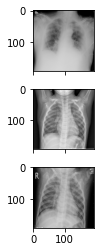

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 = preprocessor('/content/COVID-19 Radiography Database/COVID/COVID (1).png')
im2 = preprocessor('/content/COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
im3 = preprocessor('/content/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')

fig = plt.figure(figsize= (4, 4))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 1),
                 axes_pad = 0.25)

for ax, img in zip(grid, [im1, im2, im3]):
  ax.imshow(img)

plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)

print(len(y_train))
print(len(y_test))

3108
778


In [13]:
X_train.shape

(3108, 192, 192, 3)

## Defining a model

In [29]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation='relu'),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 230s 74ms/sample - loss: 0.5377 - acc: 0.7667 - val_loss: 0.5678 - val_acc: 0.7931
Epoch 2/5
3108/3108 [==============================] - 228s 74ms/sample - loss: 0.2917 - acc: 0.8967 - val_loss: 0.2159 - val_acc: 0.9229
Epoch 3/5
3108/3108 [==============================] - 227s 73ms/sample - loss: 0.2012 - acc: 0.9260 - val_loss: 0.3001 - val_acc: 0.8869
Epoch 4/5
3108/3108 [==============================] - 226s 73ms/sample - loss: 0.1611 - acc: 0.9447 - val_loss: 0.3331 - val_acc: 0.8856
Epoch 5/5
3108/3108 [==============================] - 227s 73ms/sample - loss: 0.1425 - acc: 0.9492 - val_loss: 0.2029 - val_acc: 0.9332


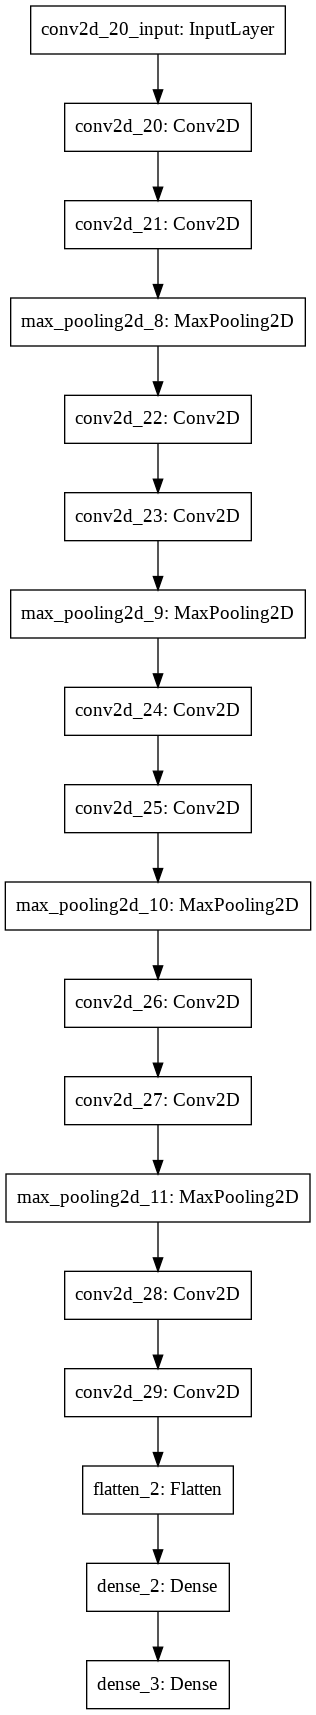

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 192, 192, 32)      896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 192, 192, 32)      1056      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 96, 96, 32)        1056      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 48, 48, 32)       

In [32]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)



In [33]:
matrix = confusion_matrix(y_test.values.argmax(axis = 1), y_pred.argmax(axis = 1))

In [34]:
pd.DataFrame(matrix, columns=categories, index = categories)

,COVID,NORMAL,Viral Pneumonia
COVID,235,1,4
NORMAL,5,241,23
Viral Pneumonia,6,13,250
